## Working with Ocean (POP) data

This notebook targets comparing CESM POP data in its original form to CESM POP data that has undergone lossy compression (meaning that the reconstructed file is not exactly equivalent to the original file). The tools provided in ldcpy are intended to highlight differences due to compression artifacts in order to assist scientist in evaluating the amount of lossy compression to apply to their data.

The POP data used here are NetCDF files in "timeseries" file format, meaning that each NetCDF file contains one (major) output variable.

 We recommend going through the tutorial notebook before this one (as it contains more introductory material).

In [1]:
# Add ldcpy root to system path
import sys

sys.path.insert(0, '../../../')
# Import ldcpy package
import ldcpy

# Autoreloads package everytime the package is called, so changes to code will be reflected in the notebook if the above sys.path.insert(...) line is uncommented.
%load_ext autoreload
%autoreload 2

# display the plots in this notebook
%matplotlib inline

# suppress all of the divide by zero warnings
import warnings

warnings.filterwarnings("ignore")

Load the sample POP data: SSH (sea surface height) and SST (sea surface temperature)

In [2]:
# SST (orig + 3 variants) - 60 days of daily data
pop_sst = ldcpy.open_datasets(
    "pop",
    ["SST"],
    [
        '../../../data/pop/pop.SST.60days.nc',
        '../../../data/pop/zfp1.0.pop.SST.60days.nc',
        '../../../data/pop/zfp1e-1.pop.SST.60days.nc',
        '../../../data/pop/zfp1e-2.pop.SST.60days.nc',
    ],
    ['orig', 'zfp1.0', 'zfp1e-1', 'zfp1e-2'],
)
# SSH (orig + 3 variants) - 12 months of monthly averages
pop_ssh = ldcpy.open_datasets(
    "pop",
    ["SSH"],
    [
        '../../../data/pop/pop.SSH.12mon.nc',
        '../../../data/pop/zfp1.0.pop.SSH.12mon.nc',
        '../../../data/pop/zfp1e-1.pop.SSH.12mon.nc',
        '../../../data/pop/zfp1e-2.pop.SSH.12mon.nc',
    ],
    ['orig', 'zfp1.0', 'zfp1e-1', 'zfp1e-2'],
)

dataset size in GB 0.12

dataset size in GB 0.03



### Comparing the data
First we compare some of the single number statistics.

In [3]:
# Look at the first time slice for SST
sst_t0 = pop_sst.isel(time=0)
ldcpy.compare_stats(sst_t0, 'SST', ['orig', 'zfp1e-1', 'zfp1e-2'])

orig  zfp1e-1  zfp1e-2
mean                   16.593   16.592   16.594
variance               117.39   117.38   117.39
standard deviation     10.835   10.834   10.835
min value             -2.1639  -2.1562  -2.1641
max value              30.528   30.523   30.528
probability positive  0.85795  0.85792  0.85795
number of zeros             0        7        1

zfp1e-1     zfp1e-2
max abs diff                          0.036346   0.0045254
min abs diff                                 0           0
mean abs diff                        0.0080806   0.0010493
mean squared diff                   2.7496e-06  4.9265e-08
root mean squared diff                0.010033   0.0013037
normalized root mean squared diff   0.00030689  3.9878e-05
normalized max pointwise error       0.0011118  0.00013843
pearson correlation coefficient              1           1
ks p-value                          3.0283e-23  0.00013815
spatial relative error(% > 0.0001)      87.395      31.902
max spatial relative error                   1      1.7397
Data SSIM                               0.9793     0.99776

In [4]:
# Look at the first time slice for SSH
ssh_t0 = pop_ssh.isel(time=0)
ldcpy.compare_stats(ssh_t0, 'SSH', ['orig', 'zfp1e-1', 'zfp1e-2'])

orig  zfp1e-1  zfp1e-2
mean                  -10.851  -10.851  -10.851
variance               5719.4   5719.3   5719.4
standard deviation     75.627   75.627   75.627
min value             -195.38  -195.38  -195.38
max value              150.47   150.47   150.47
probability positive  0.55339   0.5534  0.55339
number of zeros             0        4        1

zfp1e-1     zfp1e-2
max abs diff                          0.037424   0.0046387
min abs diff                                 0           0
mean abs diff                        0.0085802   0.0010734
mean squared diff                   5.5173e-09  2.8072e-10
root mean squared diff                0.010611   0.0013269
normalized root mean squared diff    3.068e-05  3.8366e-06
normalized max pointwise error      0.00010821  1.2651e-05
pearson correlation coefficient              1           1
ks p-value                                   1           1
spatial relative error(% > 0.0001)      62.514      12.508
max spatial relative error              10.784           1
Data SSIM                              0.99806     0.99961

If we don't want the whole list of statistics, we can get the calculations objects and request a specific calculation. This requires more lines of code, but could be useful in some situations.

In [5]:
# For SST, just get the. mean and std of the original data at the first time slice
sst_orig = pop_sst["SST"].sel(collection="orig").isel(time=0).compute()
sst_orig_m = ldcpy.calcs.Datasetcalcs(sst_orig, aggregate_dims=['nlat', 'nlon'])

sst_orig_mean = sst_orig_m.get_calc('mean')
print('mean = ', sst_orig_mean.data)

sst_orig_std = sst_orig_m.get_calc('std')
print('std = ', sst_orig_std.data)

mean =  17.870434008720704
std =  10.834812433986492


In [6]:
if 'cell_measures' in sst_orig.attrs:
    print('yes')

In [7]:
# For SST, just get the. mean and std of the "zfp1.0" data at the first time slice
sst_zfp = pop_sst["SST"].sel(collection="zfp1.0").isel(time=0).compute()
sst_zfp.attrs['cell_measures'] = 'area: cell_area'
sst_zfp_m = ldcpy.calcs.Datasetcalcs(sst_zfp, aggregate_dims=['nlat', 'nlon'])

sst_zfp_mean = sst_zfp_m.get_calc('mean')
print('mean = ', sst_zfp_mean.data)

sst_zfp_std = sst_zfp_m.get_calc('std')
print('std = ', sst_zfp_std.data)

mean =  17.847877980815536
std =  10.815969674661007


In [9]:
# For SST, get a single "diff" calc: ssim at t=0
# (note that a diff calc requires 2 sets of dataa)
sst_orig = pop_sst["SST"].sel(collection="orig").isel(time=0).compute()
sst_zfp = pop_sst["SST"].sel(collection="zfp1.0").isel(time=0).compute()
sst_diff_m = ldcpy.calcs.Diffcalcs(sst_orig, sst_zfp, aggregate_dims=['nlat', 'nlon'])

sst_ssim = sst_diff_m.get_diff_calc('ssim')
print('ssim = ', sst_ssim)

ssim =  0.9925994932337026


### Plotting the data

The main difference in plotting ocean data (vs. the atmosphere data in the tutorial notebook) is that the land masses are greyed out. Note that because data in POP over land contains Nans and the cartopy maps does not quite line up with the POP grid near Antartica, areas of NaNs are visible in the plot near the coatline of Antartica.

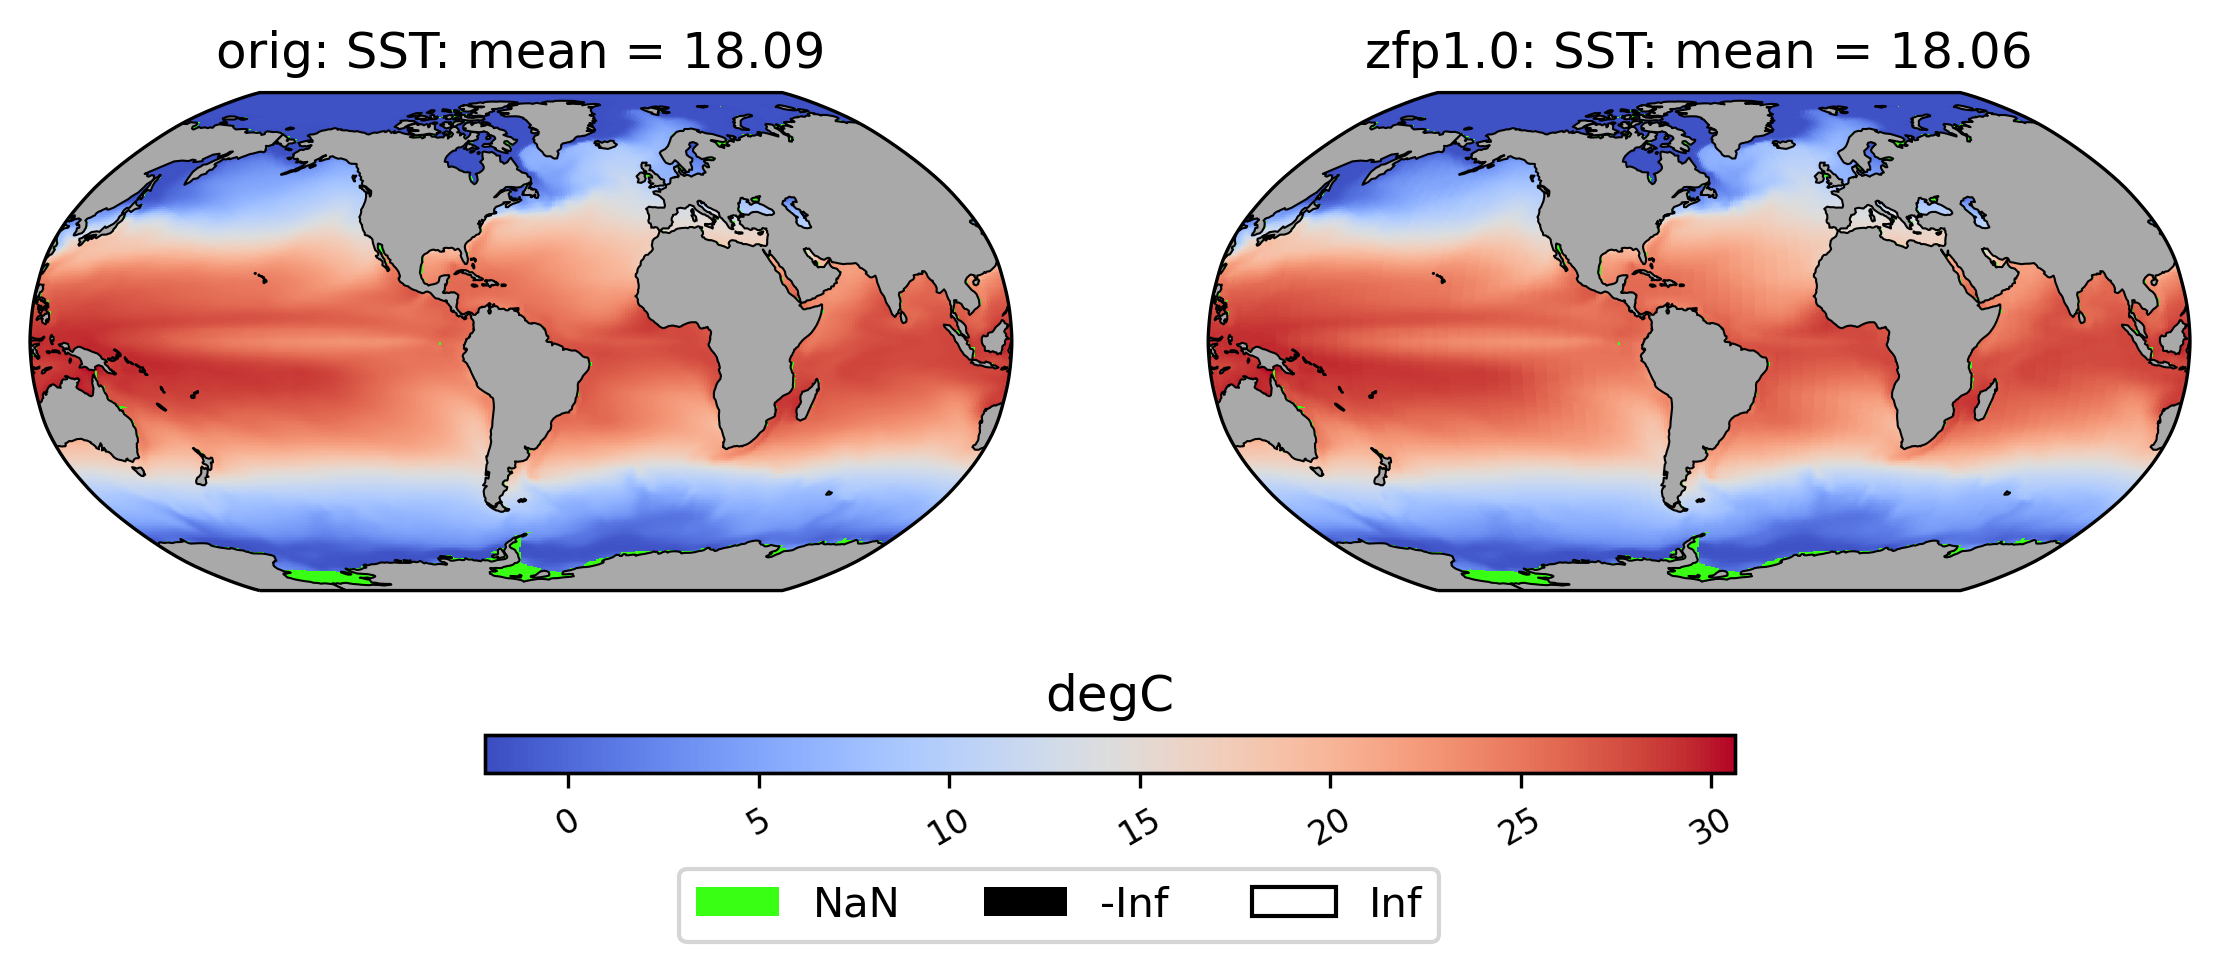

In [10]:
# Let's compare the mean (over time) for the SST with a compressed variant)
ldcpy.plot(pop_sst, "SST", sets=["orig", "zfp1.0"], calc="mean", plot_type="spatial")

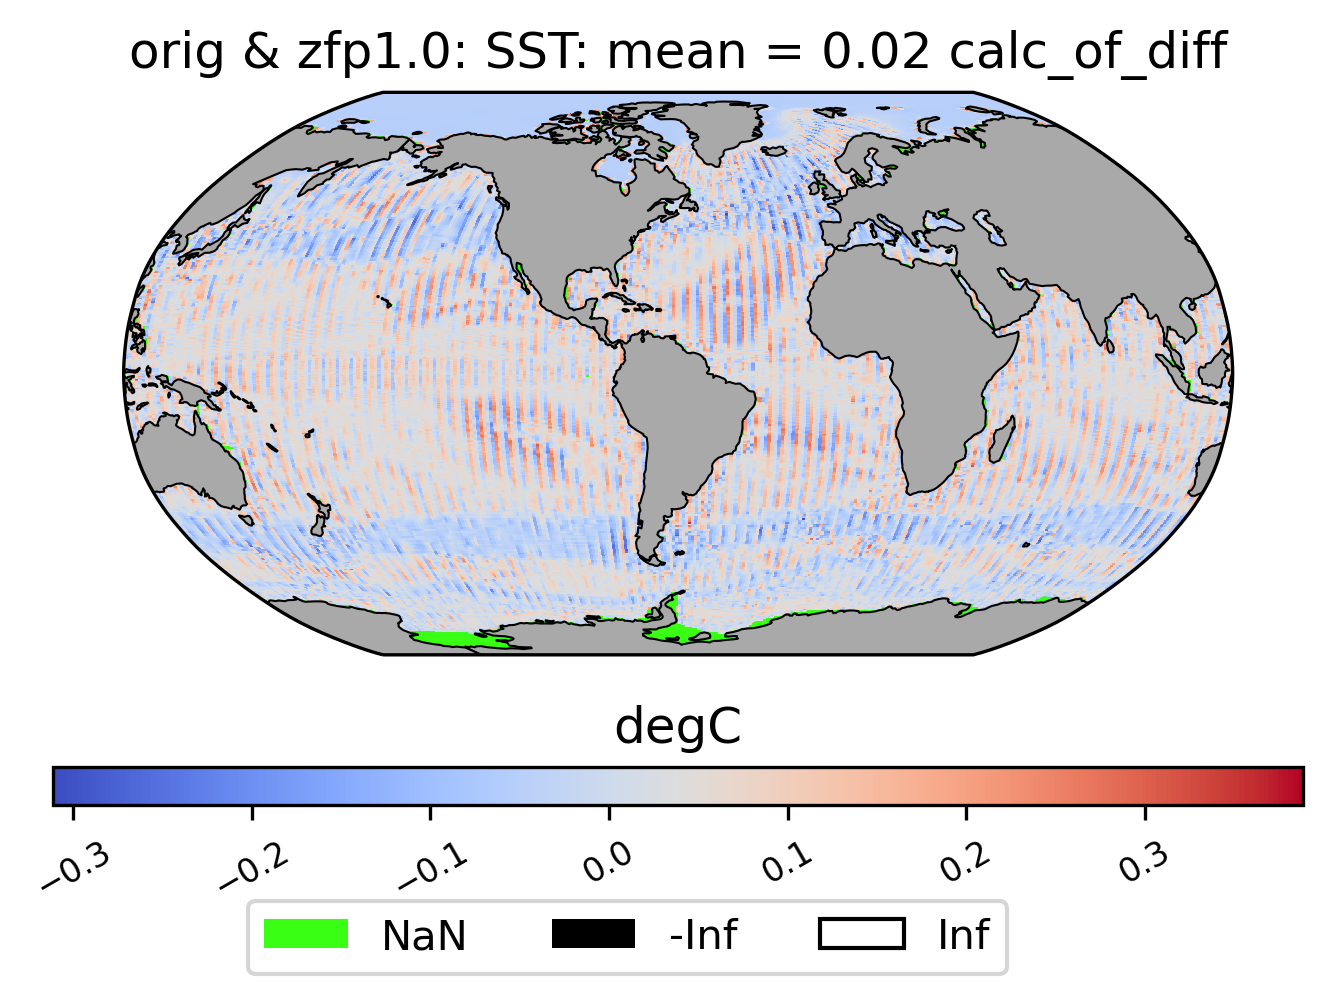

In [11]:
# Same comparison as above, but just viewing the difference
ldcpy.plot(
    pop_sst,
    "SST",
    sets=["orig", "zfp1.0"],
    calc="mean",
    calc_type="calc_of_diff",
    plot_type="spatial",
)

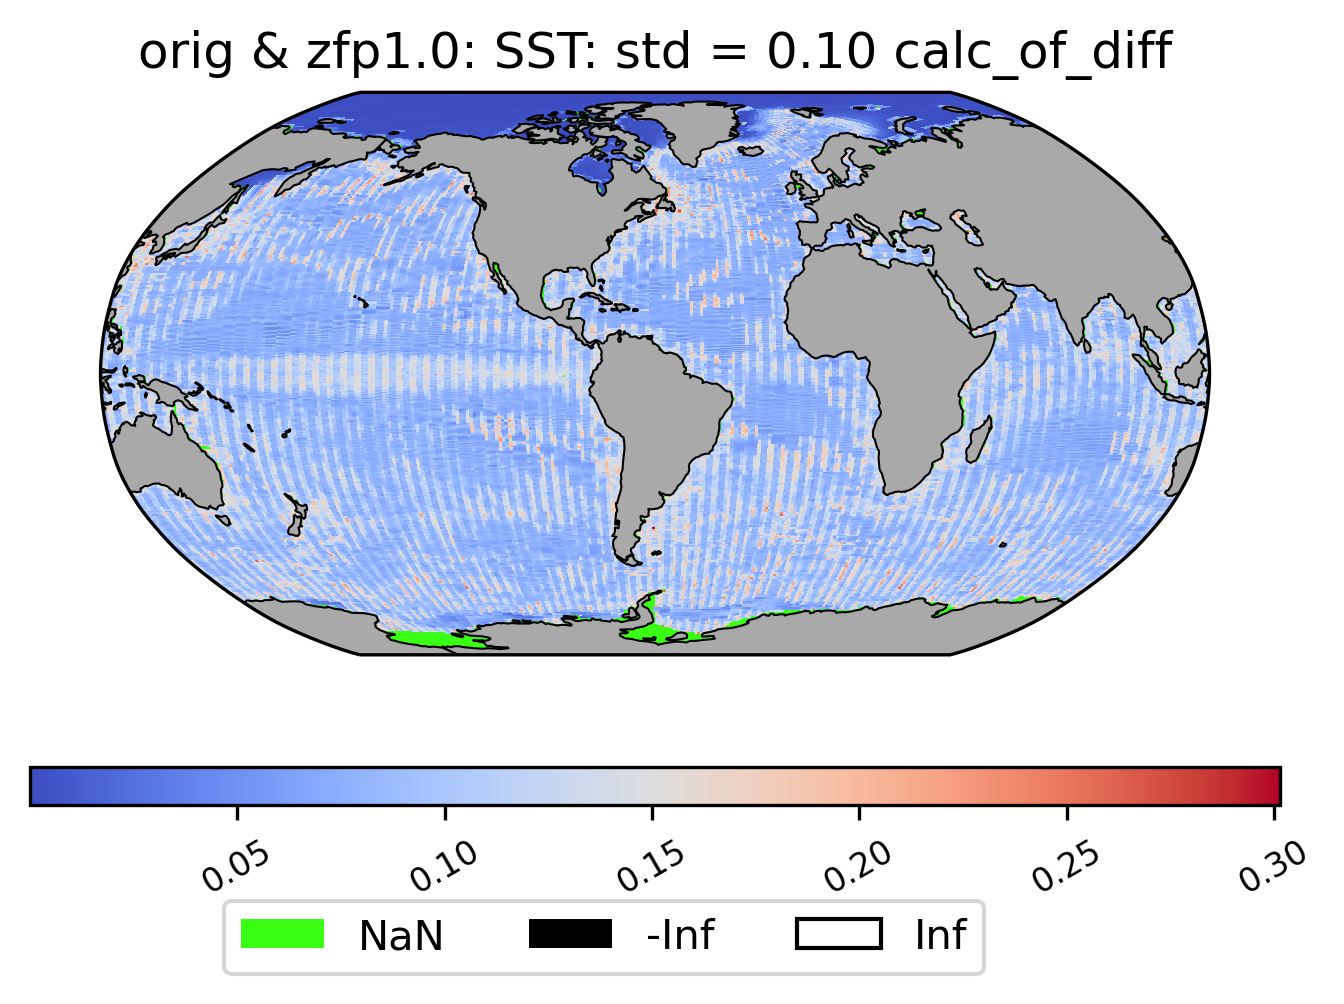

In [12]:
# We can also compare the difference in std
ldcpy.plot(
    pop_sst,
    "SST",
    sets=["orig", "zfp1.0"],
    calc="std",
    calc_type="calc_of_diff",
    plot_type="spatial",
)

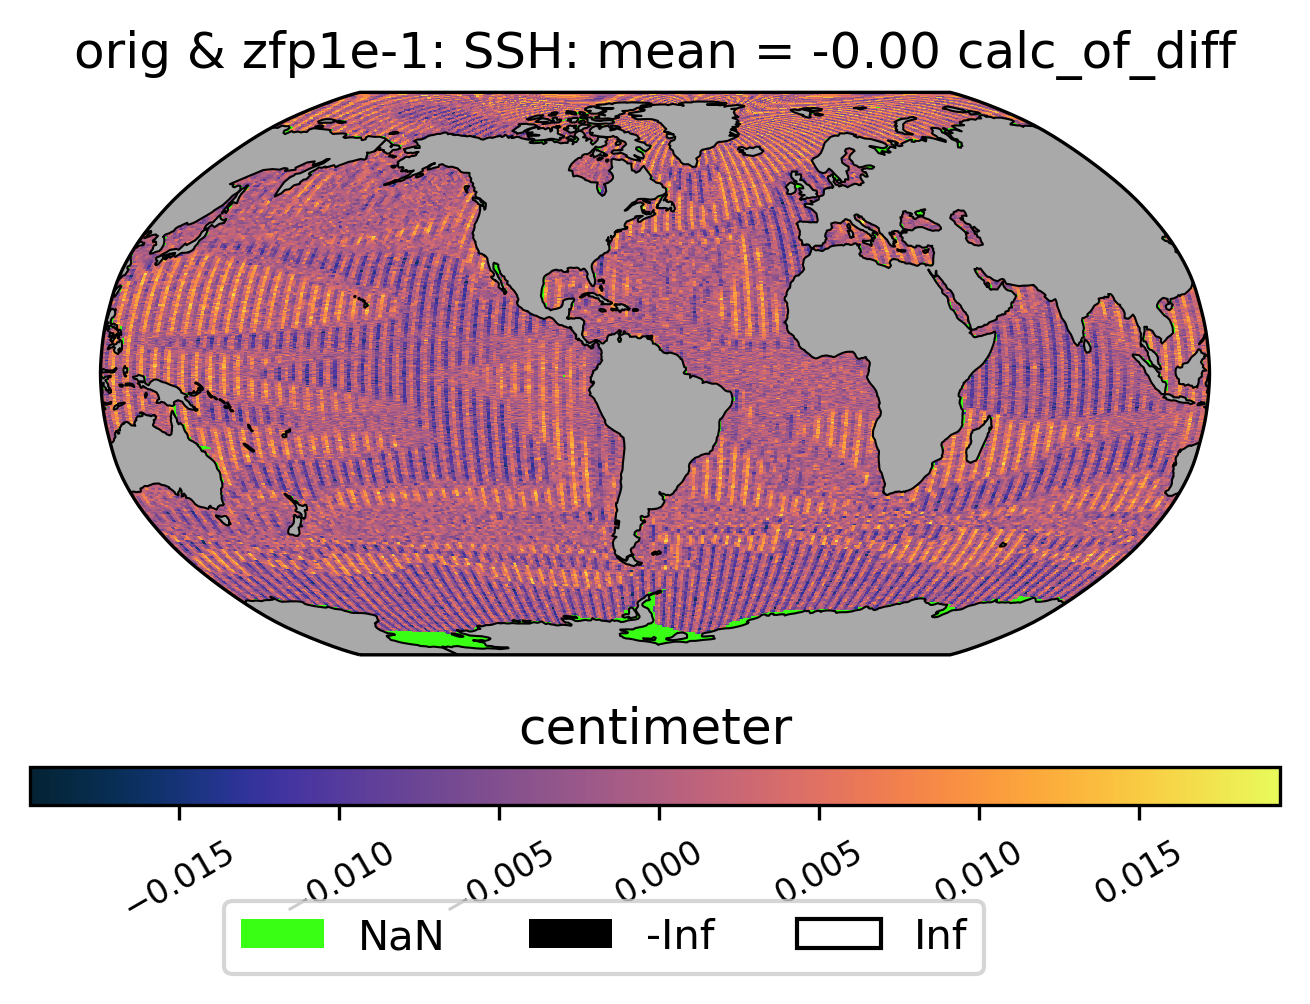

In [13]:
# Here we look at SSH - the difference in mean
ldcpy.plot(
    pop_ssh,
    "SSH",
    sets=["orig", "zfp1e-1"],
    calc="mean",
    calc_type="calc_of_diff",
    plot_type="spatial",
    color="cmo.thermal",
)

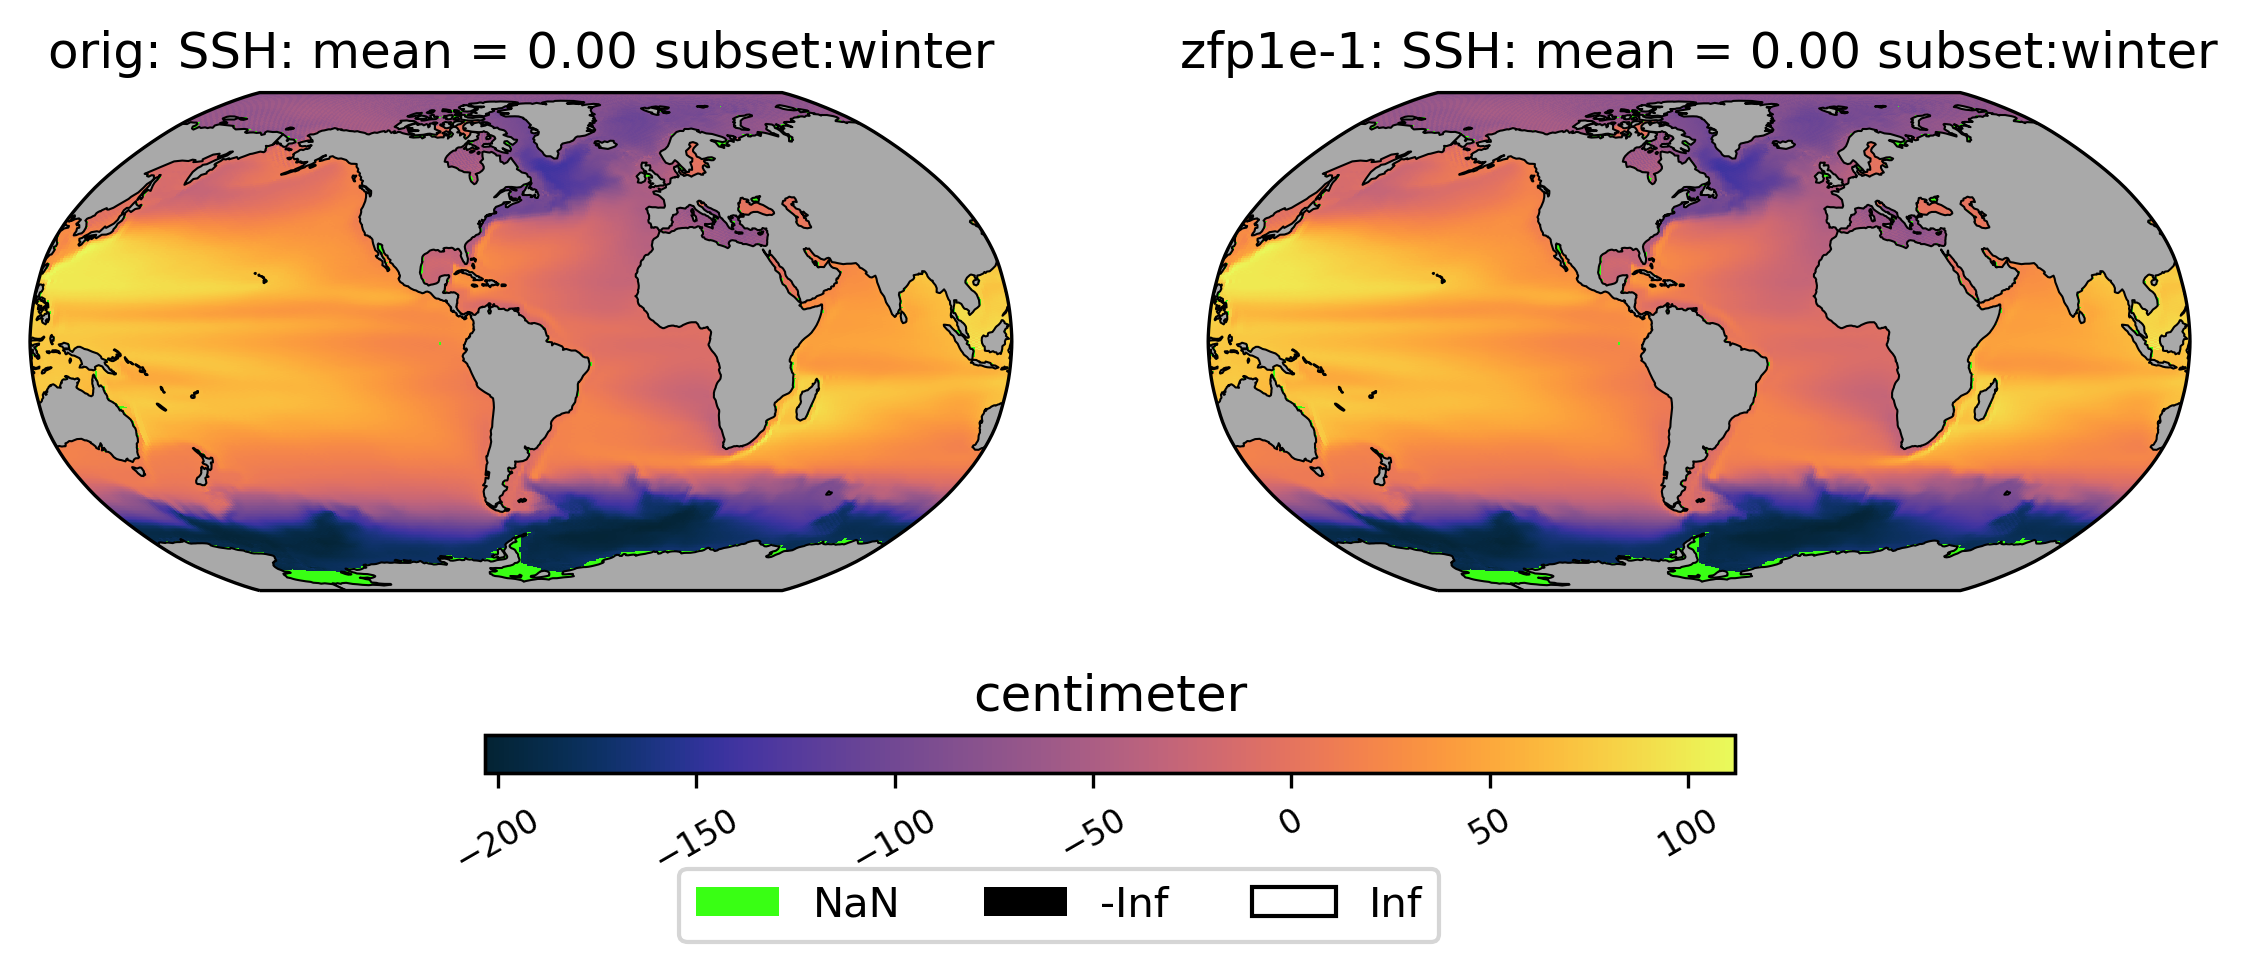

In [14]:
# Here we look at SSH mean, but just in the winter months...
ldcpy.plot(
    pop_ssh,
    "SSH",
    sets=["orig", "zfp1e-1"],
    calc="mean",
    plot_type="spatial",
    color="cmo.thermal",
    subset="winter",
)

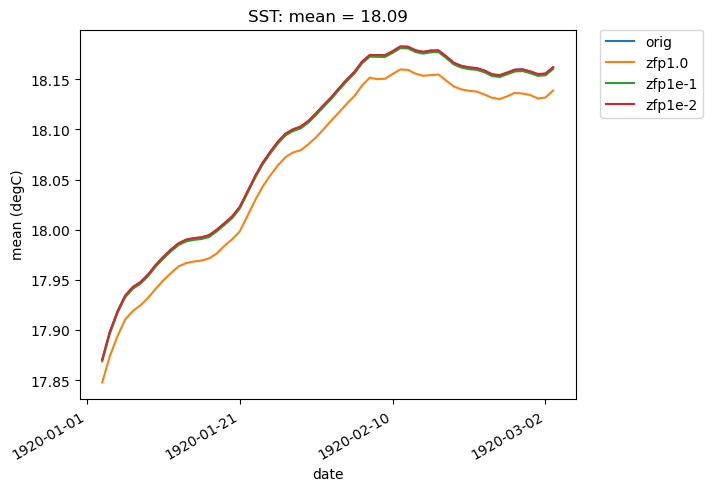

In [15]:
# Time-series plot of SST and the three compressed variants
ldcpy.plot(
    pop_sst,
    "SST",
    sets=["orig", "zfp1.0", "zfp1e-1", "zfp1e-2"],
    calc="mean",
    plot_type="time_series",
)

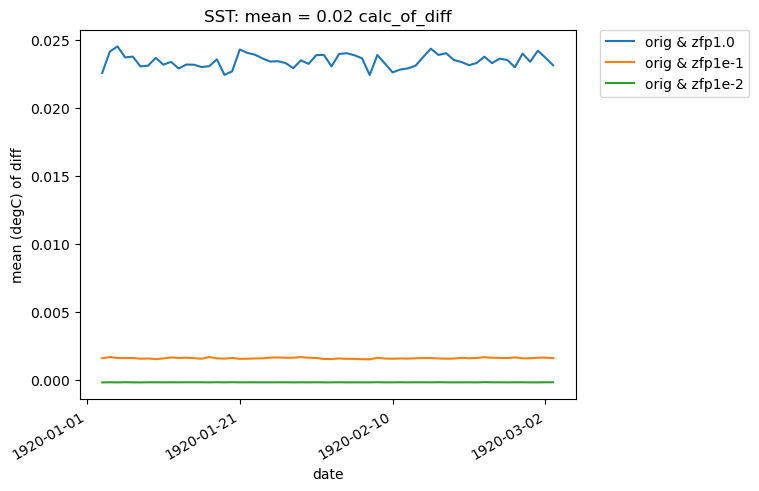

In [16]:
# We can also look at differences in a timeseries
ldcpy.plot(
    pop_sst,
    "SST",
    sets=["orig", "zfp1.0", "zfp1e-1", "zfp1e-2"],
    calc="mean",
    plot_type="time_series",
    calc_type="calc_of_diff",
)

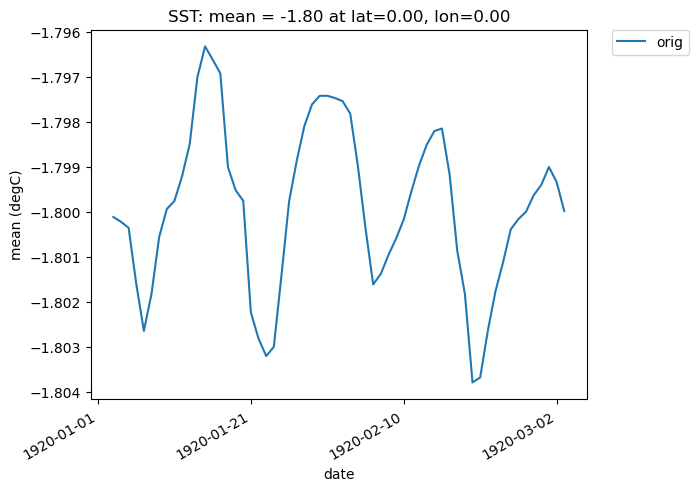

In [17]:
# Time series at a point
ldcpy.plot(
    pop_sst,
    "SST",
    sets=["orig"],
    calc="mean",
    plot_type="time_series",
    lat=85,
    lon=180,
)

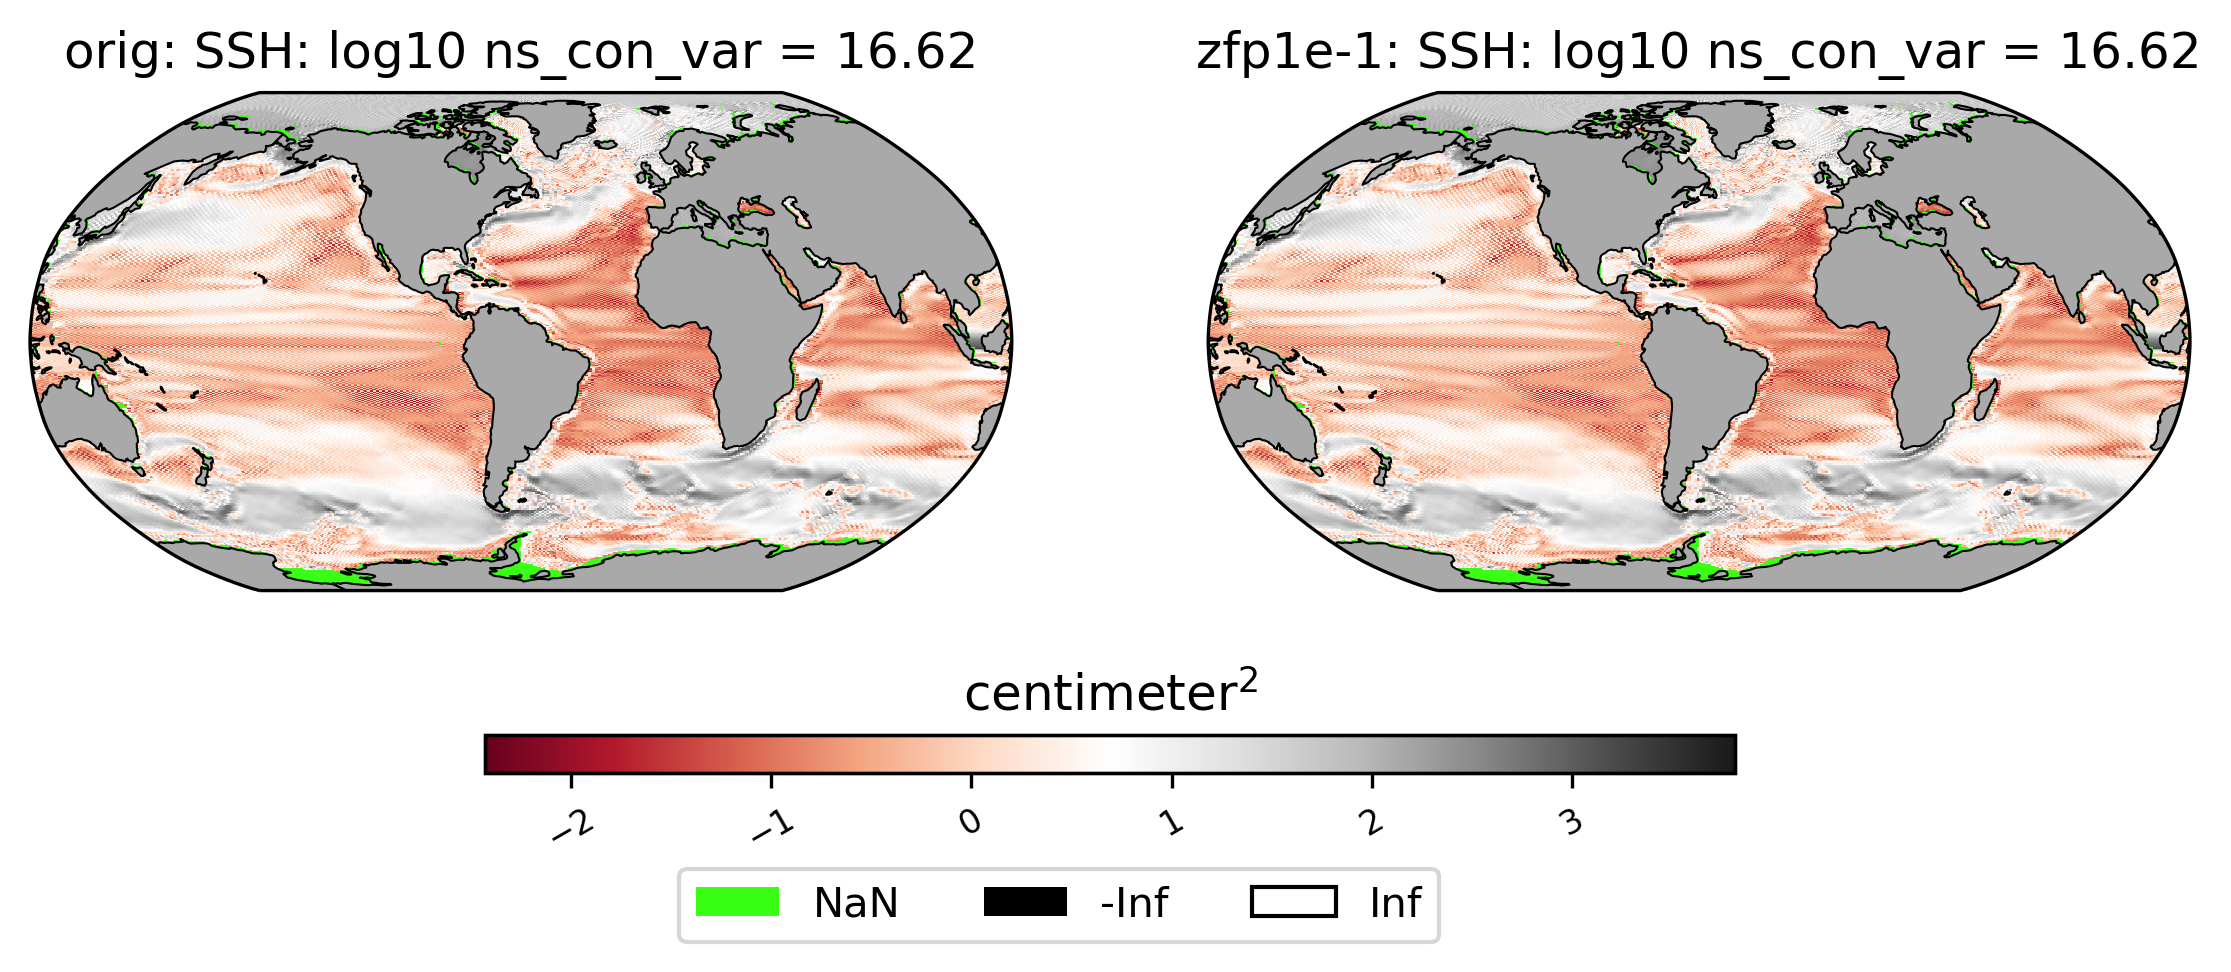

In [18]:
# N-S contrast variance
ldcpy.plot(
    pop_ssh,
    "SSH",
    sets=["orig", "zfp1e-1"],
    calc="ns_con_var",
    color="RdGy",
    calc_type="raw",
    transform="log",
)